In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
import sys
sys.path.append("./")
hf = __import__('01871834_math70076_assessment_2_helperfunction')

In [3]:
test = pd.read_csv("01871834-math70076-assessment-2-data/covid19-global-forecasting/test.csv")
train = pd.read_csv("01871834-math70076-assessment-2-data/covid19-global-forecasting/train.csv")
train.Province_State.fillna("None", inplace=True)
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())

Number of Country_Region:  184
Dates go from day 2020-05-15 to day 2020-01-22 , a total of 115 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


# 1. SIR model <a id="section2"></a>

The SIR model is a fundamental concept in epidemiology used to describe the spread of diseases like COVID-19 within a population. It divides the population into three compartments:

1. **Susceptible (S)**: Individuals who have not yet contracted the disease but are vulnerable to infection from those who are infected.
2. **Infected (I)**: Individuals who are currently carrying the disease and are capable of transmitting it to susceptible individuals.
3. **Recovered/Deceased (R)**: Individuals who have either recovered from the disease, gaining immunity, or have died. This model assumes recovered individuals do not return to the susceptible or infected states.

The SIR model uses a set of differential equations to describe the rates at which individuals move between these compartments, driven by the rates of infection and recovery:

- **Rate of change of Susceptibles**: The rate at which susceptible individuals become infected depends on the infection rate (\(\beta\)), the number of infected individuals, and their interaction with the susceptible population, given by the equation \(\frac{dS}{dt} = -\frac{\beta S I}{N}\), where \(N\) is the total population.
  
- **Rate of change of Infected**: Infected individuals increase as susceptibles get infected and decrease as infected individuals recover or die, represented by \(\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I\). Here, \(\gamma\) is the recovery rate, indicating how many infected individuals recover or die per unit time.

- **Rate of change of Recovered/Deceased**: The change in this group is solely due to recovery or death of infected individuals, modeled by \(\frac{dR}{dt} = \gamma I\).

This model helps predict the course of an epidemic by understanding how the disease spreads and what factors, such as social distancing or vaccination, might influence its dynamics. Given the simplicity of the SIR model, it serves as a good starting point for more complex models that might include additional factors like demographic changes, varying immunity, or other disease states.

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">

## 1.1. Implementing the SIR model <a id="section21"></a>

The SIR model can be executed in various ways, such as directly from the differential equations, within a mean field approximation, or by simulating the dynamics on a social network (graph). For simplicity, I have chosen to implement it using the first method. We will employ a numerical approach, specifically the Runge-Kutta method, to solve the system of differential equations.

In order to solve the differential equations system, we develop several functions and a 4rth order [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method to obtain the evolution of the disease in the `01871834_math70076_assessment_2_helperfunction.py` file.


In [4]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    Input:
    N - Total population
    b0 - Initial fraction of infected individuals
    beta - Transition rate S->I
    gamma - Transition rate I->R
    hs - Time step for the simulation
    
    Output:
    sus - Susceptible individuals
    inf - Infected individuals
    rec - Recovered individuals
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = hf.Runge_Kutta4(N, a, b, c, hf.fa, hf.fb, hf.fc, beta, gamma, hs)

    return sus, inf, rec

Results obtained for N=world population, only one initial infected case, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ are shown below:

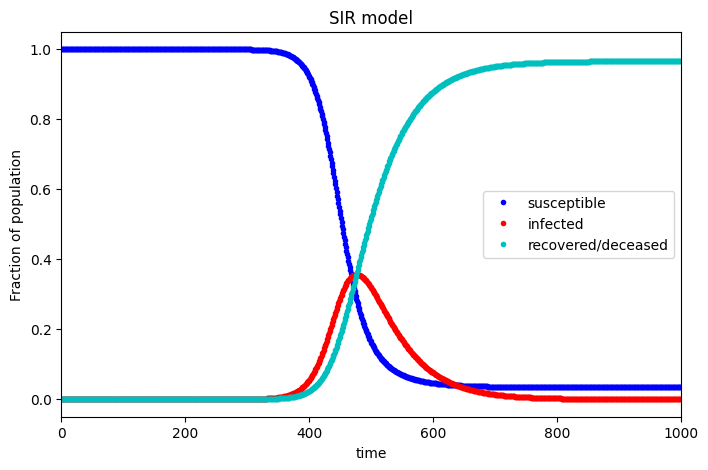

In [5]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('01871834-math70076-assessment-2-data/covid19-global-forecasting/SIR_model_example.png')
plt.show()

**Observations**:
* The count of infected individuals initially rises over a specific duration before declining as people either recover from or succumb to the illness.
* The susceptible segment of the population diminishes as the virus spreads, eventually reaching a baseline state of zero.
* Conversely, the number of recovered or deceased individuals increases.

Be aware that varying initial conditions and parameter settings can result in different outcomes. You are encouraged to adjust these figures to explore different scenarios within the system.

# 2. Data enrichment <a id="section3"></a>

The analysis of SIR simulations helps us understand the general dynamics of virus transmission, including that of COVID-19. Yet, there are alternative approaches that might be equally effective in predicting and comprehending the evolution of the pandemic. Many of these approaches depend on utilizing detailed data to draw insights and enable algorithms to identify trends and patterns. This is precisely what we'll focus on in this section.

**Main Steps of This Section:**
1. Combine data, select relevant dates, and address missing values.
2. Calculate lags and trends to understand how the virus evolves over time.
3. Incorporate details specific to different countries.

**Disclaimer**: This process of data enrichment isn't strictly necessary, and we might not use all the newly created features in our final models. Nonetheless, I view it as an educational step that will enhance our understanding, particularly through thorough exploratory analysis.

## 2.1. Join data, filter dates and clean missings <a id="section31"></a>

Initially, we'll carry out several preprocessing steps to prepare the dataset, which involve:

* **Join Data**: Merge training and testing datasets to simplify data transformations.
* **Filter Dates**: Based on the parameters of our challenge, exclude data for ConfirmedCases and Fatalities after March 12, 2020. Also, generate additional columns related to dates to facilitate analysis.
* **Missings**: Examine and rectify any missing values within the dataset to ensure data integrity and accuracy.

These steps are foundational for ensuring that the dataset is ready for further analysis and modeling.

In [6]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
                 '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-04-01', 'ConfirmedCases'] = 0
all_data.loc[all_data['Date'] >= '2020-04-01', 'Fatalities'] = 0
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-04-01'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,5,2020
13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,5,2020
13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,5,2020
13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,5,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year


**Observations**: 
Here's how to interpret the preprocessing results for the dataset:

- **Data Limitations**: The "ConfirmedCases" and "Fatalities" data are now limited to dates before March 12, 2020. This ensures that the dataset meets the specific time frame required for the challenge.
  
- **Comprehensive Dataset**: The dataset now encompasses all relevant countries and the necessary date range to facilitate the subsequent analysis of lags and trends.
  
- **Handling Missing Values**: Missing data in the "ConfirmedCases" and "Fatalities" columns have been filled with zeros. While this approach can be problematic (as it might skew the analysis if forgotten), it won't affect the predictive models since these models will be trained only on data from before March 12, 2020.
  
- **Additional Date Information**: A new column labeled "Day" has been introduced. This column acts as a counter, marking the number of days since the beginning of the dataset, which aids in time series analysis and model training.

It’s crucial to ensure that no missing values remain in the dataset after these steps. This check will confirm the dataset’s readiness for further processing and analysis, particularly in the modeling phase where data integrity is vital.

In [7]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


## 2.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is crucial for achieving accurate results. In this case, we will implement two specific transformations:

**Lag**. Lags are used to capture the value of a column from a previous day. For example, the lag 1 for "ConfirmedCases" would represent the confirmed cases from the previous day. A lag of 3 days for a feature \(X\) can be expressed as:
$$X_{lag3}(t) = X(t-3)$$

**Trend**. Transforming a column into its trend reveals its natural tendency, which is distinct from the raw value. The trend I will use is defined as:
$$Trend_{X} = \frac{X(t) - X(t-1)}{X(t-1)}$$

For "ConfirmedCases" and "Fatalities", I will calculate lags up to 14 days and trends up to 7 days.

In [8]:
ts = time.time()
all_data = hf.calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = hf.calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = hf.calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = hf.calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.14974617958068848


An example of some of the lag/trend columns for Italy is shown below:

In [9]:
all_data[all_data['Country_Region']=='Italy'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
14786,16831.0,None,Italy,2020-03-02,2036.0,52.0,-1.0,40,1694.0,1128.0,888.0,34.0,29.0,21.0
14787,16832.0,None,Italy,2020-03-03,2502.0,79.0,-1.0,41,2036.0,1694.0,1128.0,52.0,34.0,29.0
14788,16833.0,None,Italy,2020-03-04,3089.0,107.0,-1.0,42,2502.0,2036.0,1694.0,79.0,52.0,34.0
14789,16834.0,None,Italy,2020-03-05,3858.0,148.0,-1.0,43,3089.0,2502.0,2036.0,107.0,79.0,52.0
14790,16835.0,None,Italy,2020-03-06,4636.0,197.0,-1.0,44,3858.0,3089.0,2502.0,148.0,107.0,79.0
14791,16836.0,None,Italy,2020-03-07,5883.0,233.0,-1.0,45,4636.0,3858.0,3089.0,197.0,148.0,107.0
14792,16837.0,None,Italy,2020-03-08,7375.0,366.0,-1.0,46,5883.0,4636.0,3858.0,233.0,197.0,148.0
14793,16838.0,None,Italy,2020-03-09,9172.0,463.0,-1.0,47,7375.0,5883.0,4636.0,366.0,233.0,197.0
14794,16839.0,None,Italy,2020-03-10,10149.0,631.0,-1.0,48,9172.0,7375.0,5883.0,463.0,366.0,233.0
14795,16840.0,None,Italy,2020-03-11,12462.0,827.0,-1.0,49,10149.0,9172.0,7375.0,631.0,463.0,366.0


## 2.3. Add country details <a id="section33"></a>

Factors such as a country's total population, the average age of its citizens, or the percentage of people residing in urban areas can significantly influence the transmission dynamics of COVID-19. Therefore, it is essential to take these variables into account. For this analysis, I am utilizing [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) which is derived from web scraping, to include these factors.

In [10]:
# Load countries data file
world_population = pd.read_csv("01871834-math70076-assessment-2-data/covid19-global-forecasting/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1440297825,153,9388211,38,61
1,India,1382345085,464,2973190,28,35
2,US,331341050,36,9147420,38,83
3,Indonesia,274021604,151,1811570,30,56
4,Pakistan,221612785,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4993,50,100,19,10
231,Falkland Islands,3497,0,12170,19,66
232,Niue,1628,6,260,19,46
233,Tokelau,1360,136,10,19,0


Joined dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,Afghanistan,39074280.0,60.0,652860.0,18.0,25.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,Afghanistan,39074280.0,60.0,652860.0,18.0,25.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,Afghanistan,39074280.0,60.0,652860.0,18.0,25.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,Afghanistan,39074280.0,60.0,652860.0,18.0,25.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,Afghanistan,39074280.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45067,13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,Zimbabwe,14899771.0,38.0,386850.0,19.0,38.0
45068,13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,Zimbabwe,14899771.0,38.0,386850.0,19.0,38.0
45069,13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,Zimbabwe,14899771.0,38.0,386850.0,19.0,38.0
45070,13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,Zimbabwe,14899771.0,38.0,386850.0,19.0,38.0


Encoded dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,83,0,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,0.0,39074280.0,60.0,652860.0,18.0,25.0
1,1,2.0,83,0,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,0.0,39074280.0,60.0,652860.0,18.0,25.0
2,2,3.0,83,0,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,0.0,39074280.0,60.0,652860.0,18.0,25.0
3,3,4.0,83,0,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,0.0,39074280.0,60.0,652860.0,18.0,25.0
4,4,5.0,83,0,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,0.0,39074280.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45067,13454,-1.0,83,183,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,0.0,14899771.0,38.0,386850.0,19.0,38.0
45068,13455,-1.0,83,183,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,0.0,14899771.0,38.0,386850.0,19.0,38.0
45069,13456,-1.0,83,183,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,0.0,14899771.0,38.0,386850.0,19.0,38.0
45070,13457,-1.0,83,183,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,0.0,14899771.0,38.0,386850.0,19.0,38.0


# 3. Predictions for the early stages of the transmission <a id="section4"></a>

In this section, our goal is to predict the early trajectory of the COVID-19 pandemic using a data-centric approach, treating it like any typical regression problem. It's important to note that according to the challenge guidelines, submissions on the public leaderboard should only include data up until March 26, 2020.

**Models to be Applied**:
1. **Linear Regression for All Countries (Method 1)**: This approach will use a standard linear regression model to estimate the spread of COVID-19 across all countries. The model will be calibrated using the available data leading up to the specified date.
2. **Linear Regression for All Countries (Method 2)**: This method involves another variation of linear regression, potentially using different features or assumptions, to provide an alternative perspective on the predicted expansion of the virus.

These models will help in understanding the initial spread patterns and may offer insights into the effectiveness of early interventions across different regions.

In [11]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)

## 3.1 Linear Regression for all countries (method 1) <a id="section42"></a>

We've encountered issues when using only 10 historical data points in our model, which negatively affect the performance of our Linear Regressor. To determine if this is a widespread issue, we need to test the model across all countries. Here’s a structured approach to do this:

**Steps to Generalize the Model for All Countries:**

1. **Loop for Each Country**: Start by iterating over each country included in the dataset. This will allow us to apply the model individually to each country and assess the performance consistently across different regions.
   
2. **Compute Provinces List**: For each country, identify if there are any provinces or states with separate data points. This step is crucial as the impact of COVID-19 can vary significantly within different regions of the same country.

3. **Conditional Model Application**:
   - **If Provinces Exist**: If the current country has province-level data, apply the Linear Regressor separately to each province. This approach helps to tailor the model to localized trends and variations, providing a more accurate prediction at the regional level.
   - **If No Provinces**: If there are no provinces or only national-level data is available, apply the Linear Regressor directly to the country-wide data. 

4. **Run the Linear Regressor**: Execute the regression analysis for each province or country as applicable. This involves fitting the model to the historical data points and assessing its predictive accuracy.

In [12]:
ts = time.time()
day_start = 65
train_lim, test_lim = 69, 112
data_pred = hf.linreg_basic_all_countries(data, day_start, train_lim, test_lim)
hf.get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities', '01871834-math70076-assessment-2-data/covid19-global-forecasting/lin_reg_method_1_submission.csv')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Linear Regression for all countries
Process finished in  2.66  seconds


It seems that the linear regression model has difficulty handling the variability and transitional periods that are prominent at the beginning of the COVID-19 data set. Such early fluctuations tend to distort the regression outcomes, leading to biased predictions. Based on the experiments, this method does not appear to be effective for this type of analysis, especially during the initial stages of the outbreak when data changes can be abrupt and significant.

As a result, I have chosen not to use this method in future analyses. However, the approach is still available for those who might want to explore its utility for different analytical purposes.

Regarding the performance of the model:
- The final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) recorded for the second week, using training data up to March 19, 2020, and assessing it on April 1, 2020, stands at **1.19681**. This score reflects some level of predictive accuracy but also indicates significant potential for improvement. Better results might be achieved by using alternative modeling approaches or enhancing the model’s ability to manage early data anomalies and outliers in subsequent analyses.

## 3.2 Linear Regression for all countries (method 2) <a id="section43"></a>

An alternative approach to determining the training period duration is to use all available data from each country starting from the date of the first confirmed case. However, this method might lead to biases in the predictions, particularly for countries where the initial outbreak progressed slowly. For instance, in Spain, there was only one confirmed case daily for seven consecutive days, which could skew the predictive accuracy if these early data points dominate the training set.

In [13]:
ts = time.time()

# Set the dataframe where we will update the predictions
day_start = 65
data2 = data.loc[data.Day_num >= day_start]
data_pred3 = data2[data2.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred3['Predicted_ConfirmedCases'] = [0]*len(data_pred3)
data_pred3['Predicted_Fatalities'] = [0]*len(data_pred3)
how_many_days = test.Date.nunique()
    
print("Currently running Linear Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = hf.split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = hf.lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = hf.lin_reg(X_train, Y_train_2, X_test)
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = hf.split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = hf.lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = hf.lin_reg(X_train, Y_train_2, X_test)
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
data_pred3.replace([np.inf, -np.inf], 0, inplace=True) 

hf.get_submission(data_pred3, 'Predicted_ConfirmedCases', 'Predicted_Fatalities', '01871834-math70076-assessment-2-data/covid19-global-forecasting/lin_reg_method_2_submission.csv')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Linear Regression for all countries
Process finished in  0.61  seconds


Based on my testing, this approach does not work well with our linear regression model. Often, the initial transition periods heavily influence the model, leading to biased results. Therefore, I will not be using this method in future sections, although it may still be useful for other applications.

The final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, calculated with training data up to March 19, 2020, and evaluated on April 1, 2020, is:

**1.62190**

Considering all the previous findings, I am fairly confident that Linear Regression is an effective method for analyzing the early stages of COVID-19's spread. This applies specifically to the initial outbreak phase we are examining, and it's important to acknowledge that our model isn't designed to predict when the number of new infections will decline. However, for short-term forecasting, this approach is adequate, and we are prepared to make further improvements to enhance our results.

# 4. Predictions for the late stages of the transmission (under construction)<a id="section5"></a>

As the disease transmission evolves, **we move away from the exponential phase** and the Linear Regressor we've been using starts to deliver poorer predictions. We anticipated this issue and now recognize that **new methods are needed** to accurately model the changing patterns of the spread.

I want to emphasize that the goal of this section is to forecast the near-term progression of case numbers, not to determine when the peak of infections will occur or predict the overall scope of COVID-19 spread in each country.

Models we will explore in this section include:

1. Logistic curve fit on single country.
2. Logistic curve fit applied to all countries

## 4.1. Logistic curve fit <a id="section51"></a>

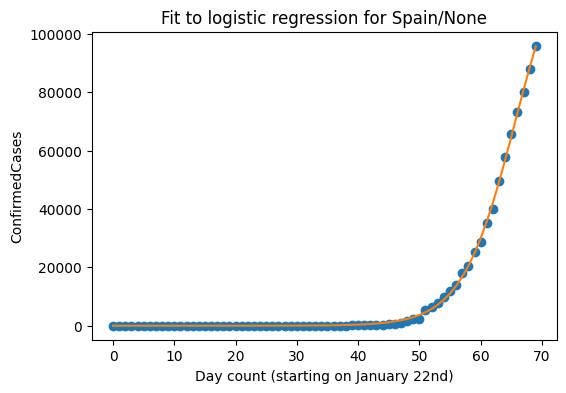

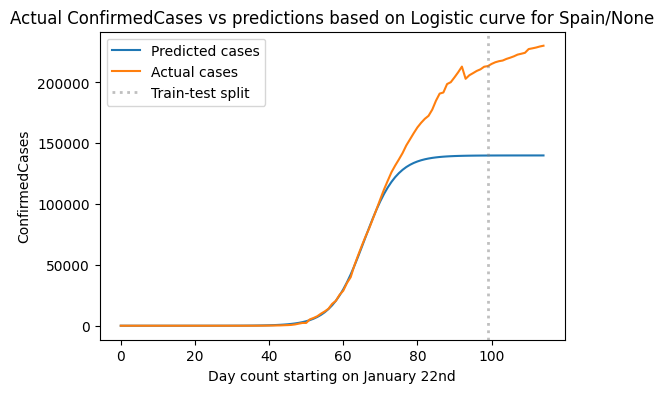

In [14]:
def fit_logistic(all_data, country_name, province_name, train_lim, target):
    data_cp = all_data.loc[(all_data['Country_Region']==country_dict[country_name]) & (all_data['Province_State']==province_dict[province_name])]
    y = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(hf.logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = hf.logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

# Fit country to logistic curve
country_name = 'Spain'
province_name = 'None'
train_lim = 69
valid_lim = 84 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 

x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
hf.plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
hf.plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Italy**

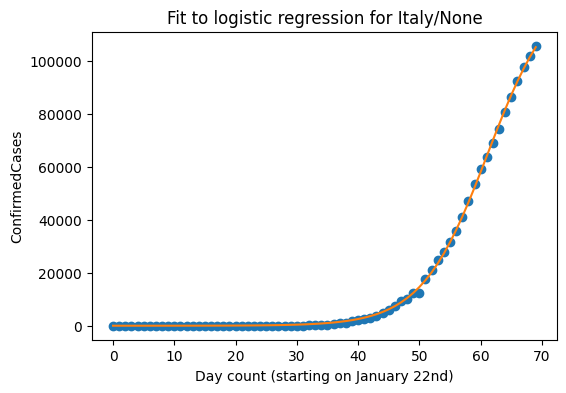

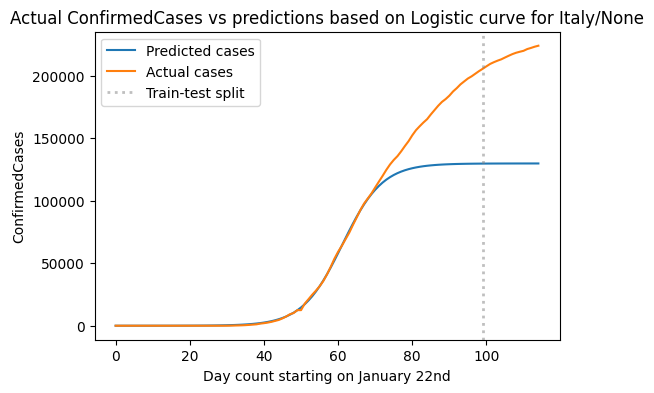

In [15]:
# Fit country to logistic curve
country_name = 'Italy'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
hf.plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
hf.plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Germany**

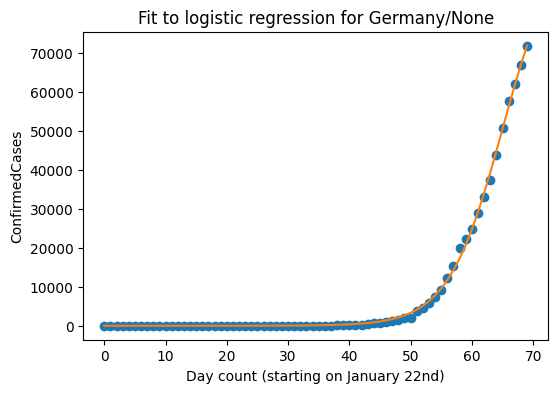

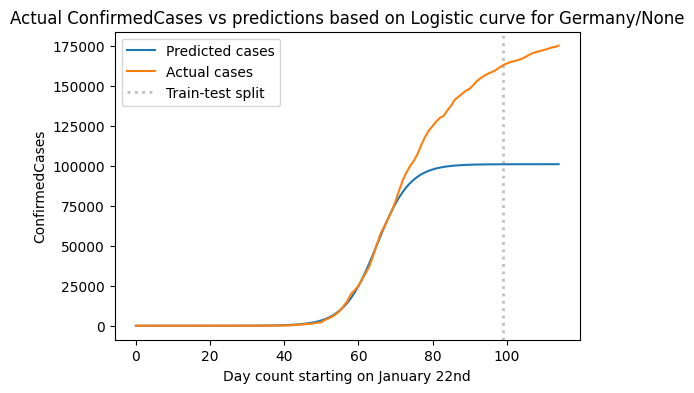

In [16]:
# Fit country to logistic curve
country_name = 'Germany'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
hf.plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
hf.plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Albania**

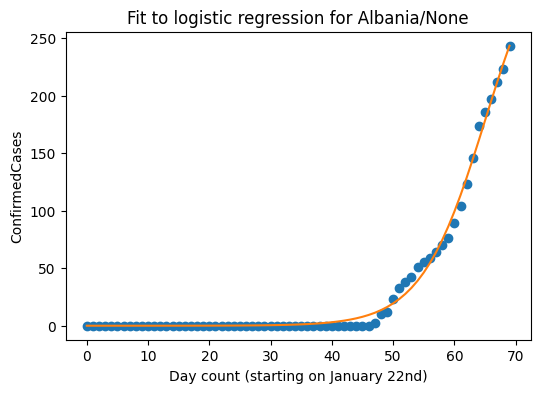

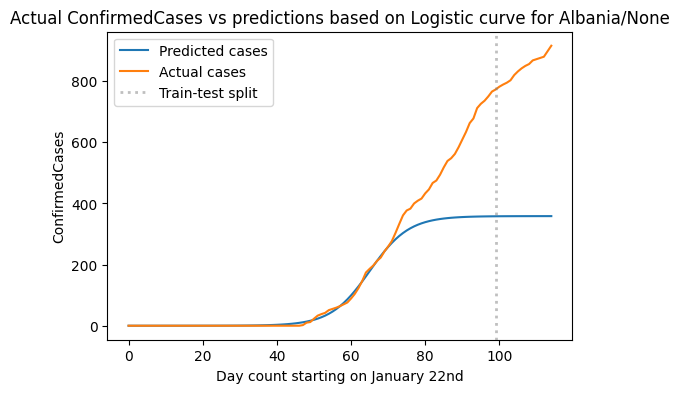

In [17]:
# Fit country to logistic curve
country_name = 'Albania'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
hf.plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
hf.plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **China/Hubei**

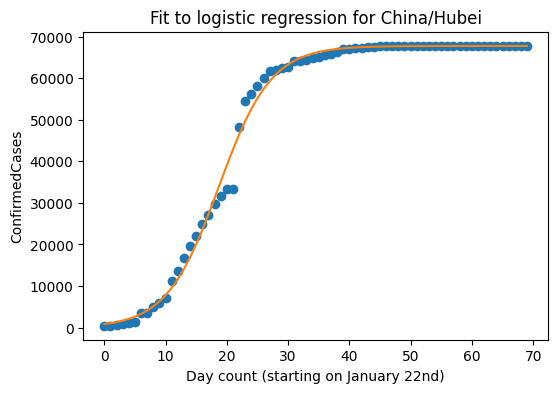

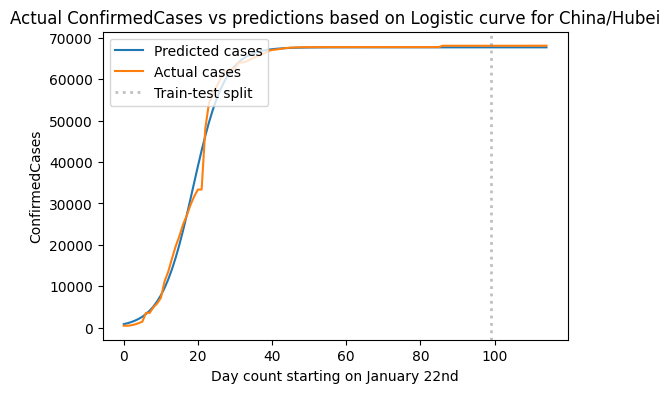

In [18]:
# Fit country to logistic curve
country_name = 'China'
province_name = 'Hubei'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
hf.plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
hf.plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

**Observations**:

From the above image, we can observe:

1. The logistic regression fit is good for all countries, suggesting that the model captures the general trend of the data effectively across different regions. This indicates that the logistic model is robust in representing the growth pattern of the epidemic until a certain point of saturation.

2. Only China's forecast aligns with the actual trend, while the other countries are all below the predicted values. Several reasons could account for this discrepancy:
   - **Data Accuracy and Reporting Differences**: Variations in how countries report COVID-19 cases can impact the accuracy of the model predictions. For example, changes in testing rates and methodologies can lead to underreporting or delays in data that affect model output.
   - **Government Response and Public Compliance**: The extent and effectiveness of government interventions (such as lockdowns, social distancing measures, and travel restrictions) and public compliance can significantly influence the spread of the virus and, consequently, the accuracy of predictions.
   - **Initial Conditions and Model Assumptions**: The initial conditions set for the model and the assumptions regarding transmission rates and recovery might not hold uniformly across all countries. For instance, cultural, demographic, and health infrastructure differences can alter the disease's transmission dynamics, leading to deviations from modeled predictions.

These factors suggest that while logistic regression models provide a useful framework for understanding and predicting COVID-19 trends, they must be adapted or supplemented with additional data and insights to improve accuracy across diverse global contexts.

## 4.2. Logistic curve fit for all countries <a id="section52"></a>

In [19]:
def logistic_forecast_allcountries(all_data, train, train_lim, test_lim):
    
    ts = time.time()
    data_pred = all_data[all_data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    # Main loop for countries
    for country_name in train['Country_Region'].unique():
        for province_name in train[train['Country_Region']==country_name]['Province_State'].unique():
            
            # ConfirmedCases
            x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
            pred_1 = [hf.logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
            data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & (data_pred['Province_State']==province_dict[province_name])), 'Predicted_ConfirmedCases'] = pred_1

            # Fatalities
            x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'Fatalities')
            pred_2 = [hf.logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
            data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & (data_pred['Province_State']==province_dict[province_name])), 'Predicted_Fatalities'] = pred_2


    print("Logistic function fit for all countries finished in ", round(time.time() - ts, 2), " seconds")
    return data_pred

train_lim = 69
test_lim = 112
    
logistic_forecast = logistic_forecast_allcountries(all_data, train, train_lim, test_lim) 
hf.get_submission(logistic_forecast, 'Predicted_ConfirmedCases', 'Predicted_Fatalities', '01871834-math70076-assessment-2-data/covid19-global-forecasting/logistic_regression_submission.csv')

Logistic function fit for all countries finished in  284.31  seconds


Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01: 

**1.12791**

**Conclusion**:

When analyzing the outcomes from both the logistic curve fit and the linear regression model, it is evident that the logistic model outperforms the linear model in predicting the progression of COVID-19 during the outbreak's later phases, achieving lower LMSE scores. The logistic model's superior performance can be attributed to its ability to effectively model the saturation point of the epidemic. This feature is vital for accurate predictions as the rate of new infections gradually decreases. The logistic model incorporates the concept of a carrying capacity, which reflects the maximum number of infected individuals that the environment can sustain, thus allowing it to account for the slowdown in infection rates that naturally occurs as the population of susceptible individuals diminishes and public health interventions take effect. This makes the logistic model particularly useful for forecasting the tail end of the epidemic curves where traditional linear models may fail to adjust to the changing dynamics of the disease spread.